## load data + cleaning

In [385]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [386]:
def first_aid(df):
    temp = 'data/'+df+'.csv'
    df = pd.read_csv(temp , sep =',', names = list(range(0,30)))
    df = df[[4,0,5,1,2,3]+list(range(6,29))]
    df[5] = df[5].map(lambda x: x.lstrip('מספר תגובות -'))
    df.columns = ['url','data','number_comment','name','title']+list(range(1,25))
    return df

joy = first_aid('pain')
bowel_diseases = first_aid('bowel_diseases')
joints = first_aid('joints')
psoriasis = first_aid('psoriasis')
sclerosis = first_aid('sclerosis')

## organize data + future engineer
### Collect names in one column

In [387]:
def isNaN(num):
    #check if isNaN
    return num != num
def extract_name(dat,i,j):
    #get a cell, and extracts the name and response
    if not isinstance(dat,str):
        print('Mistake at point'+ str(i)+' ' + str(j) + 'Does not send string')
        return ['','']
    x1 = dat.find('XX')
    x2 = dat.rfind('XX')
    if x1 or x2 <0:
        print("Can't find Name"+ str(i) + "," + str(j))
        return['','']
    name = dat[x1+2:x2]
    text = dat[x2+2:]
    if len(name) > 30:
        print("Can't extract Name"+ str(i) + "," + str(j))
        return ['','']
    return [name,text]

def listToString(s):
    str1 = ""
    for ele in s:
        str1 += ele
        str1 += ","
    return str1
def organize_name(df):
    #Gets DF and deletes the responses from the names and centers them in one cell
    dim = df.shape
    for i in range(0,dim[0]):
        name = [df.loc[i,'name']]
        for j in range(6,dim[1]):
            dat = df.iloc[i,j]
            if not isNaN(dat):
                save_cell = extract_name(dat,i,j)
                df.iloc[i,j] = save_cell[1]
                name.append(save_cell[0])
            else:
                break
        df.loc[i,'name'] = listToString(name)
    return df
joy = organize_name(joy)
#bowel_diseases = organize_name(bowel_diseases)
#joints = organize_name(joints)
#psoriasis = organize_name(psoriasis)
#sclerosis = organize_name(sclerosis)

joy1 = joy.copy()



Can't extract Name121,9
Can't extract Name361,11


### clean the text

In [388]:
import itertools
 
def delete_word(item,delete_list):
    # delete words form the cell
    for word in delete_list:
        item = ''.join(re.split(word,item))
        if word in item:
            loc = item.find(word)
            while loc > -1:
                length_w = len(word)
                item = item[:loc] + item[loc+length_w:]
                loc = item.find(word)
    return item


def regex_remove(item,list_ex):
    for reg in list_ex:
        pattern = re.compile(reg)
        item = pattern.sub('', item)
    return item

def clean_df(item):
    #get cell and list of word that not allowed to be contain in the cell
    #return the cell clean
    delete_list = ['&nbsp;','&quot;',"&#39;"]
    list_regex = ['<.+?>','\S*@\S*\s?','http\S+',"\d{2}\d*-\d{7}"]
    #list reg  =    <>   ,   email      , web  ,   phone number
    if isNaN(item):
        return item
    item = delete_word(item,delete_list)
    item = regex_remove(item,list_regex)
    return item





def run_over_DF(df,fun):
#Unfortunately applymap run to MemoryError: in some case. This function overcomes this obstacle
    dim = df.shape
    for i in range(0,dim[0]):
    #for i in range(0,1000):
        if i % 100 == 0:
            print('#',i)
        for j in range(4,dim[1]):
            dat = fun(df.iloc[i,j])
            df.iloc[i,j] = dat
    return df
joy = run_over_DF(joy,clean_df)

#bowel_diseases = bowel_diseases.applymap(clean_df)
#joints = joints.applymap(clean_df)
#psoriasis = psoriasis.applymap(clean_df)
#sclerosis = sclerosis.applymap(clean_df)

# 0
# 100
# 200
# 300
# 400
# 500
# 600
# 700
# 800
# 900
# 1000
# 1100
# 1200
# 1300


## Tokenize

In [389]:
def split_DF_to_word(df):
    #Gets DF and returns a list of the words from all columns and rows
    #Preparing to graph: plot_20_common
    dim = df.shape
    all_words = []
    for i in range(0,dim[0]):
        if i % 100 == 0:
            print('#',i)
        for j in range(4,dim[1]):
            cell = df.iloc[i,j]
            if not isNaN(cell):
                cell = re.sub(r'[?.,\/#!$%\^&\*;:{}=\-_`~()]', ' ', cell)
                temp = cell.split()
                all_words = all_words + temp
            else:
                break
    return all_words

def clean_stop_word(lst,stop = ''):
    if len(stop) == 0:
        stop = list(pd.read_csv('heb_stopwords.txt', sep='\n', header=None)[0])
    temp = []
    for word in lst:
        if word not in stop:
            temp.append(word)
    return temp
joy_lemma = split_DF_to_word(joy)
joy_lemma = clean_stop_word(joy_lemma)


# 0
# 100
# 200
# 300
# 400
# 500
# 600
# 700
# 800
# 900
# 1000
# 1100
# 1200
# 1300


## Visualization data


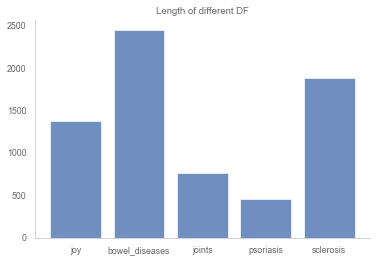

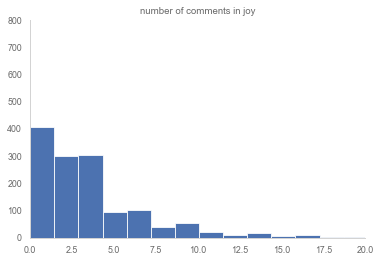

In [390]:
from add_style import *

table = [joy,bowel_diseases,joints,psoriasis,sclerosis]
x = []
for df in table:
    x.append(df.shape[0])
y=['joy','bowel_diseases','joints','psoriasis','sclerosis']
plt.bar(y, x, align='center', alpha=0.8)
plt.title("Length of different DF")
plt.show()

def hist_comment(df,name_DF):
    save = df['number_comment'].tolist()
    save = list(map(int, save))
    plt.hist(save,bins=50)
    plt.axis([0, 20, 0, 800])
    plt.title('number of comments in '+name_DF)
    plt.show()


hist_comment(joy,'joy')


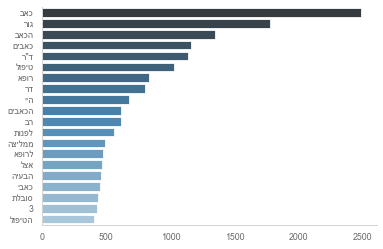

In [391]:
def invert_words_list(words_list):
    #Reverses the direction of the words so that the graphs in Hebrew will be readable
    return [word[::-1] for word in words_list]

def plot_common(words, n=20):
    #Gets text divided into tokens, pulls out a graph
    word_count = Counter(words)
    most=word_count.most_common(n)
    x, y= zip(*most)
    sns.barplot(x=y,y=invert_words_list(x),palette=("Blues_d"))
    sns.set_context("paper")

plot_common(joy_lemma, 20)



(('ד"ר', 'גור'), ('דר', 'גור'), ('למרפאת', 'כאב'), ('במרפאת', 'כאב'), ('מרפאת', 'כאב'), ('תופעות', 'לוואי'), ('גור', 'כאב'), ('ממליצה', 'לפנות'), ('בדיקות', 'דם'), ('לפנות', 'למרפאת'), ('כאבים', 'חזקים'), ('גור', 'כאבים'), ('פריצת', 'דיסק'), ('רופא', 'כאב'), ('בצד', 'שמאל'), ('כאב', 'כרוני'), ('לפנות', 'לרופא'), ('לרופא', 'כאב'), ('אצל', 'רופא'), ('סובלת', 'מכאבים'))
(993, 680, 334, 245, 150, 149, 140, 131, 118, 106, 104, 99, 95, 93, 87, 86, 84, 79, 75, 75)


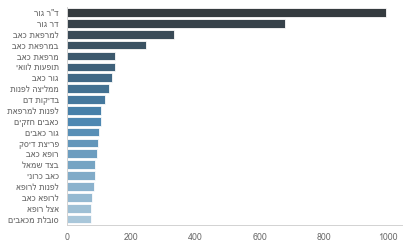

In [392]:
def find_ngrams(input_list, n):
  return list(zip(*[input_list[i:] for i in range(n)]))

def plot_top_ngrams_barchart(text, n=2):
    grams = find_ngrams(text,2)
    grams = Counter(grams)
    grams = grams.most_common(20)
    x,y = zip(*grams)
    temp = []
    for element in x:
        temp.append(' '.join(element))
    sns.barplot(x=y,y=temp)
    sns.barplot(x=y,y=invert_words_list(temp),palette=("Blues_d"))
    sns.set_context("paper")


plot_top_ngrams_barchart(joy_lemma,n=1)

## cloud word


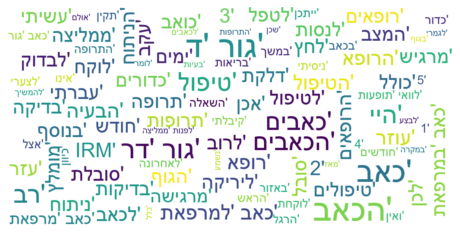

In [393]:
from wordcloud import WordCloud

wordcloud = WordCloud(
        background_color='white',
        max_words=100,
        max_font_size=30,
        font_path='arial',
        scale=3,
        random_state=1)


temp1 = []
comment_words = ''
for word in joy_lemma:
    temp1.append(word[::-1])

wordcloud=wordcloud.generate(str(temp1))

plt.figure(1, figsize = (8, 8))
plt.axis('off')
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

#TODO: we need to get rid with '
# also, we need to find out how to convert the order of words
#example: כאב למרפאת